In [1]:
%pip install tensorflow

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.1.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, precision_recall_curve
from imblearn.over_sampling import SMOTE
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
import joblib
import tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.optimizers import Adam

In [3]:
df = pd.read_csv('dataset/creditcard_2023.csv')
print("Dataset loaded successfully!")
print(df.info())
print(df.head())

Dataset loaded successfully!
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 568630 entries, 0 to 568629
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   id      568630 non-null  int64  
 1   V1      568630 non-null  float64
 2   V2      568630 non-null  float64
 3   V3      568630 non-null  float64
 4   V4      568630 non-null  float64
 5   V5      568630 non-null  float64
 6   V6      568630 non-null  float64
 7   V7      568630 non-null  float64
 8   V8      568630 non-null  float64
 9   V9      568630 non-null  float64
 10  V10     568630 non-null  float64
 11  V11     568630 non-null  float64
 12  V12     568630 non-null  float64
 13  V13     568630 non-null  float64
 14  V14     568630 non-null  float64
 15  V15     568630 non-null  float64
 16  V16     568630 non-null  float64
 17  V17     568630 non-null  float64
 18  V18     568630 non-null  float64
 19  V19     568630 non-null  float64
 20  V20     568630 non-

In [4]:

# Check for Missing Values
print("Checking for missing values...")
print(df.isnull().sum())


Checking for missing values...
id        0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64


In [5]:
# Feature Scaling
scaler = StandardScaler()
df['Amount'] = scaler.fit_transform(df[['Amount']])
print("Features scaled.")

Features scaled.


In [6]:
# Handle Class Imbalance with SMOTE
X = df.drop(columns=['Class'])
y = df['Class']
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)
y_resampled = y_resampled.astype(int)
print(f"Resampled class distribution: {np.bincount(y_resampled)}")

Resampled class distribution: [284315 284315]


In [7]:
# Split Data into Train and Test
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, stratify=y_resampled, random_state=42)
print("Data split into training and testing sets.")

Data split into training and testing sets.


In [8]:
# Train Random Forest Model
rf_model = RandomForestClassifier(random_state=42, n_estimators=100, max_depth=10)
rf_model.fit(X_train, y_train)
print("Random Forest model trained.")

Random Forest model trained.



Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56863
           1       1.00      1.00      1.00     56863

    accuracy                           1.00    113726
   macro avg       1.00      1.00      1.00    113726
weighted avg       1.00      1.00      1.00    113726


Confusion Matrix:


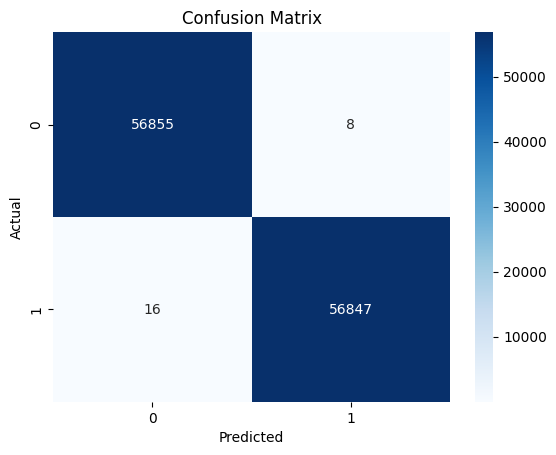


ROC AUC Score: 0.9999961146171176


In [9]:
# Evaluate Model
y_pred = rf_model.predict(X_test)
y_proba = rf_model.predict_proba(X_test)[:, 1]
print("\nClassification Report:")
print(classification_report(y_test, y_pred))
print("\nConfusion Matrix:")
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

print(f"\nROC AUC Score: {roc_auc_score(y_test, y_proba)}")

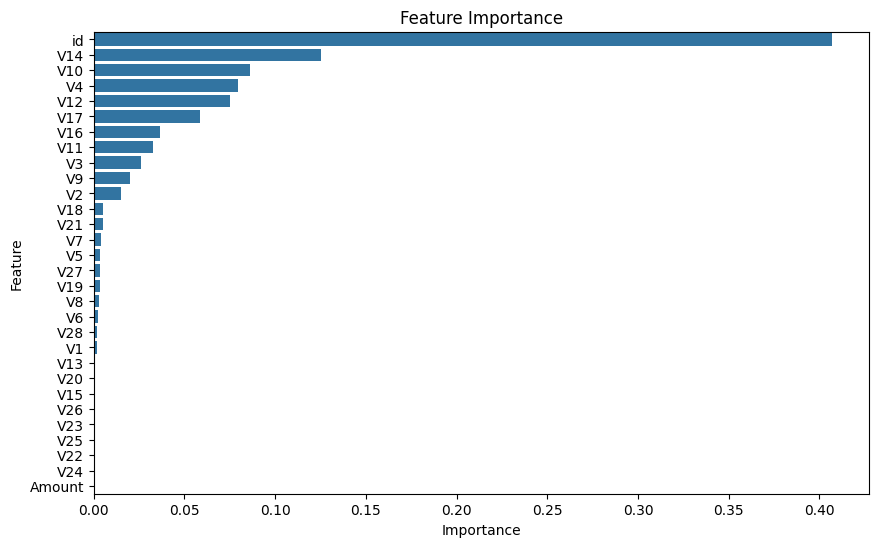

In [10]:
# Feature Importance
importances = rf_model.feature_importances_
feature_names = X.columns
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title('Feature Importance')
plt.show()

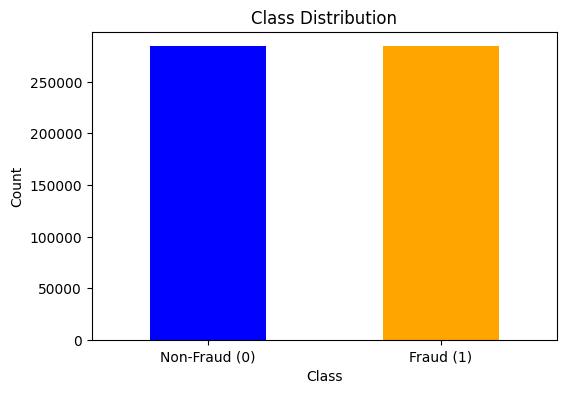

In [11]:
# Class Distribution Visualization
class_counts = df['Class'].value_counts()
plt.figure(figsize=(6, 4))
class_counts.plot(kind='bar', color=['blue', 'orange'])
plt.title('Class Distribution')
plt.xticks([0, 1], ['Non-Fraud (0)', 'Fraud (1)'], rotation=0)
plt.ylabel('Count')
plt.show()

C:\Users\shipra aeron\AppData\Local\Temp\ipykernel_20216\1223628710.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Class', y='Amount', data=df, palette='Set2')


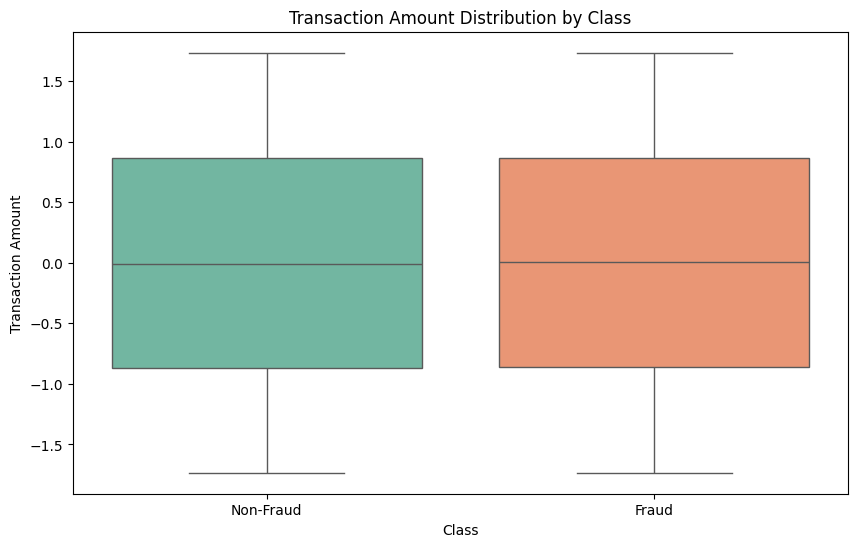

In [12]:
# Boxplot for Amount by Class
plt.figure(figsize=(10, 6))
sns.boxplot(x='Class', y='Amount', data=df, palette='Set2')
plt.title('Transaction Amount Distribution by Class')
plt.xticks([0, 1], ['Non-Fraud', 'Fraud'])
plt.ylabel('Transaction Amount')
plt.show()

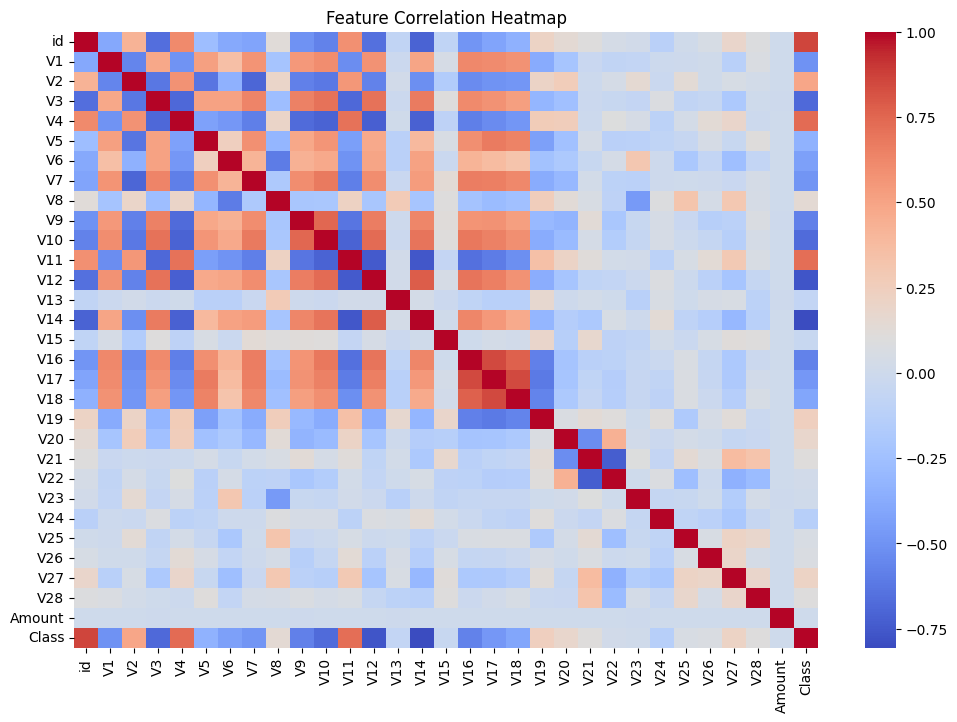

In [13]:
# Correlation Heatmap
corr_matrix = df.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, cmap='coolwarm', annot=False, fmt='.2f')
plt.title('Feature Correlation Heatmap')
plt.show()

c:\Users\shipra aeron\Fraud Detection System\venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


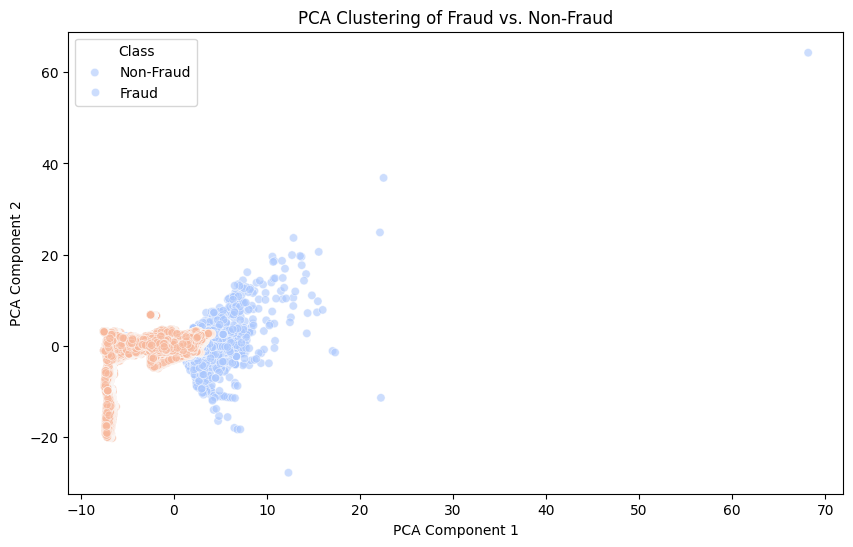

In [14]:
# PCA for Visualization
X_scaled = scaler.fit_transform(X)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=y, palette='coolwarm', alpha=0.6)
plt.title('PCA Clustering of Fraud vs. Non-Fraud')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend(title='Class', labels=['Non-Fraud', 'Fraud'])
plt.show()

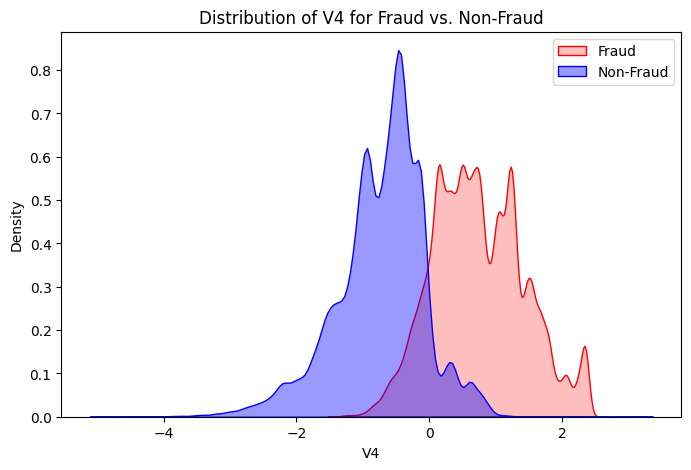

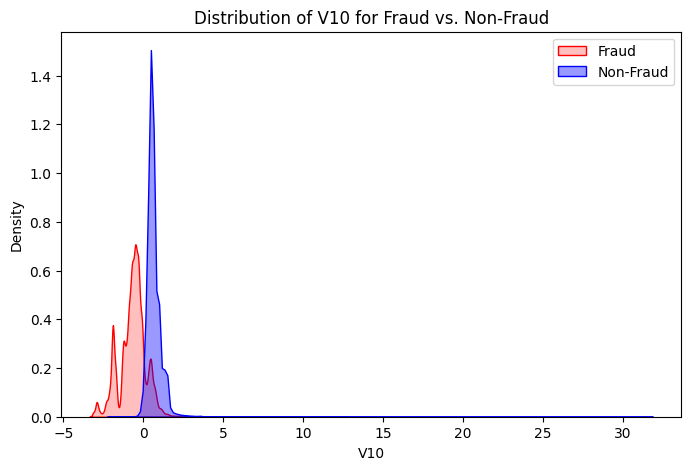

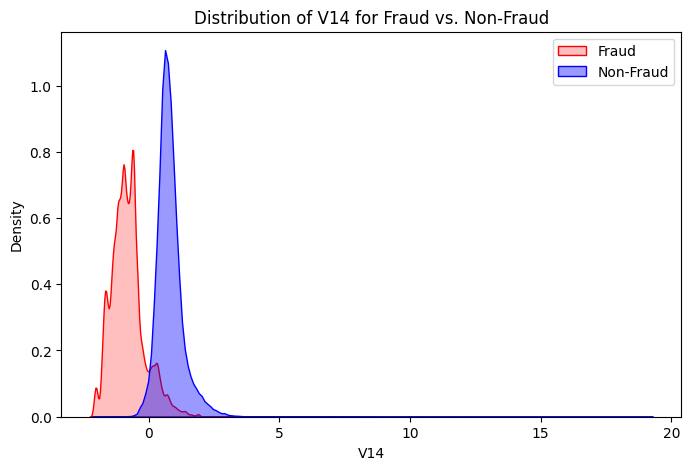

In [17]:
fraud = df[df['Class'] == 1]
non_fraud = df[df['Class'] == 0]

highly_corr_features = ['V4', 'V10', 'V14']  # Example features; replace based on correlation analysis
for feature in highly_corr_features:
    plt.figure(figsize=(8, 5))
    sns.kdeplot(fraud[feature], color='red', label='Fraud', fill=True)
    sns.kdeplot(non_fraud[feature], color='blue', label='Non-Fraud', fill=True, alpha=0.4)
    plt.title(f'Distribution of {feature} for Fraud vs. Non-Fraud')
    plt.legend()
    plt.show()

In [15]:
# Deep Learning Model: LSTM for Fraud Detection
X_train_dl = np.expand_dims(X_train, axis=2)
X_test_dl = np.expand_dims(X_test, axis=2)

lstm_model = Sequential([
    LSTM(64, input_shape=(X_train_dl.shape[1], X_train_dl.shape[2]), return_sequences=True),
    Dropout(0.2),
    LSTM(32),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

lstm_model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
lstm_model.fit(X_train_dl, y_train, validation_data=(X_test_dl, y_test), epochs=10, batch_size=32)

c:\Users\shipra aeron\Fraud Detection System\venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
14216/14216 ━━━━━━━━━━━━━━━━━━━━ 945s 66ms/step - accuracy: 0.9478 - loss: 0.1430 - val_accuracy: 0.9860 - val_loss: 0.0328
Epoch 2/10
14216/14216 ━━━━━━━━━━━━━━━━━━━━ 928s 65ms/step - accuracy: 0.9901 - loss: 0.0271 - val_accuracy: 0.9918 - val_loss: 0.0265
Epoch 3/10
14216/14216 ━━━━━━━━━━━━━━━━━━━━ 967s 68ms/step - accuracy: 0.9955 - loss: 0.0144 - val_accuracy: 0.9966 - val_loss: 0.0126
Epoch 4/10
14216/14216 ━━━━━━━━━━━━━━━━━━━━ 2487s 175ms/step - accuracy: 0.9972 - loss: 0.0099 - val_accuracy: 0.9961 - val_loss: 0.0135
Epoch 5/10
14216/14216 ━━━━━━━━━━━━━━━━━━━━ 1039s 73ms/step - accuracy: 0.9977 - loss: 0.0084 - val_accuracy: 0.9974 - val_loss: 0.0082
Epoch 6/10
 3289/14216 ━━━━━━━━━━━━━━━━━━━━ 3:36 20ms/step - accuracy: 0.9982 - loss: 0.0062

KeyboardInterrupt: 

In [16]:
# Evaluate LSTM Model
lstm_pred = (lstm_model.predict(X_test_dl) > 0.5).astype(int)
print("\nLSTM Model Classification Report:")
print(classification_report(y_test, lstm_pred))

3554/3554 ━━━━━━━━━━━━━━━━━━━━ 16s 4ms/step

LSTM Model Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56863
           1       1.00      1.00      1.00     56863

    accuracy                           1.00    113726
   macro avg       1.00      1.00      1.00    113726
weighted avg       1.00      1.00      1.00    113726

